# Investigate Model

In [1]:
import os
import imp
import sys
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.utils import plot_model
from keras import models
import geopandas as gpd

Using TensorFlow backend.


In [2]:
#-- Set up configurations / parameters
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
ratio = 727 # penalization ratio for GL and non-GL points based on smaller dataaset
mod_lbl = 'atrous' #'unet'
n_test = 500
if mod_lbl == 'unet':
  mod_str = '{0}_{1}init_{2}down_drop{3:.1f}_customLossR{4}'.format(mod_lbl,ninit,ndown,
                                                        dropout_frac,ratio)
elif mod_lbl == 'atrous':
  mod_str = '{0}_{1}init_drop{2:.1f}_customLossR{3}'.format(mod_lbl,ninit,dropout_frac,ratio)
else:
  print('model label not matching.')
print(mod_str)

atrous_32init_drop0.2_customLossR727


In [3]:
#-- Directory setup
gdrive =  os.path.expanduser('~/Google Drive File Stream')
colabdir = os.path.join(gdrive,'My Drive','Colab Notebooks')
ddir = os.path.join(gdrive,'Shared drives','GROUNDING_LINE_TEAM_DRIVE','ML_Yara','geocoded_v1')
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)
output_dir = os.path.expanduser('~/GL_learning_data/')

In [4]:
#-- Get list of images
fileList = os.listdir(test_dir)

In [5]:
fname = 'gl_069_181124-181130-181206-181212_013745-024816-013920-024991_T110456_T110456_x1536_y0512_DIR11'
file_ind = fileList.index('coco_%s.npy'%fname)
im = np.load(os.path.join(test_dir,fileList[file_ind]))
h,wi,ch = im.shape

In [6]:
#-- also read the corresponding shapefile
shpfile = os.path.join(output_dir,'geocoded_v1','stitched.dir','atrous_32init_drop0.2_customLossR727.dir',\
                       'shapefiles.dir','%s_6.0km.shp'%fname.split('_x')[0])
gdf = gpd.read_file(shpfile)

In [7]:
x,y = gdf['geometry'][4].coords.xy
x,y = np.array(x),np.array(y)
x1 = x.min() - 2e5
x2 = x.max() + 2e5
y1 = y.min() - 2e5
y2 = y.max() + 2e5

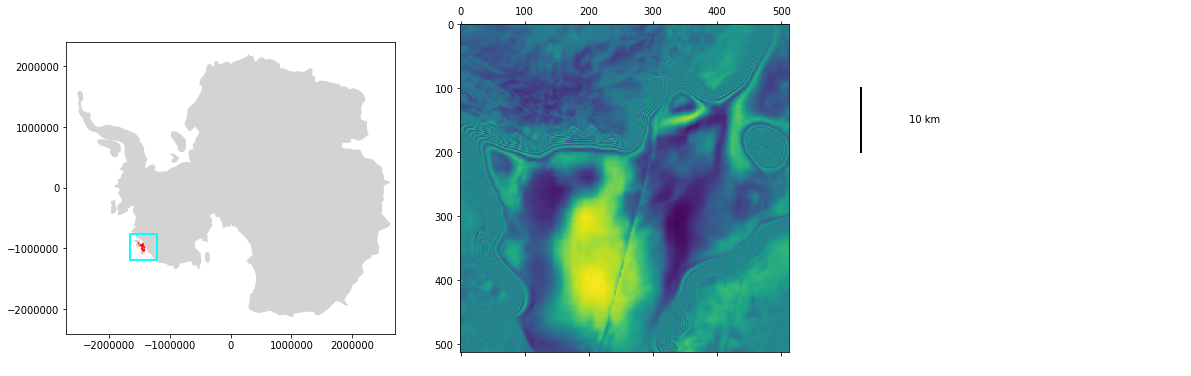

In [8]:
fig,ax = plt.subplots(1,3,figsize=(20,10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(gdf.crs)
world.plot(ax=ax[0],color='lightgray', edgecolor='lightgray')
ax[0].set_xlim([-2700000,2700000])
ax[0].set_ylim([-2400000,2400000])
# ax[0].set_xlim([-2600000,1.6e6])
# ax[0].set_ylim([-2200000,1.6e6])
gdf.plot(ax=ax[0],color='red', edgecolor='red')
ax[0].plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],color='cyan',linewidth=2)

ax[1].matshow(im[:,:,0])
#-- add scale bar
ax[2].set_xlim([0,wi])
ax[2].set_ylim([h,0])
ax[2].plot([10,10],[100,200],color='black',linewidth=2.)
ax[2].text(110,150,'10 km',horizontalalignment='center',\
    verticalalignment='center', color='black')
ax[2].axis('off')
for i in range(3):
    ax[i].set_aspect('equal')

In [12]:
fig= plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

world.plot(ax=ax, color='lightgray', edgecolor='lightgray')
ax.set_xlim([-2700000,2700000])
ax.set_ylim([-2400000,2400000])
gdf.plot(ax=ax,color='red', edgecolor='red')
ax.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],color='black',linewidth=3)
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(output_dir,'antarctic_inset_pipeline-figure.pdf'),format='PDF')
plt.close()

In [65]:
#-- Import model
mod_module = imp.load_source('nn_model',os.path.join(colabdir,'nn_model.py'))
#-- set up model
if mod_lbl == 'unet':
  print('loading unet model')
  model = mod_module.unet_model_double_dropout(height=h,width=wi,channels=ch, 
                                        n_init=ninit,n_layers=ndown,
                                        drop=dropout_frac)
elif mod_lbl == 'atrous':
  print("loading atrous model")
  model = mod_module.nn_model_atrous_double_dropout(height=h,width=wi,
                                                channels=ch,
                                                n_filts=ninit,
                                                drop=dropout_frac)
else:
  print('Model label not correct.')

loading atrous model


In [66]:
#-- define custom loss function
def customLoss(yTrue,yPred):
  return -1*K.mean(ratio*(yTrue*K.log(yPred+1e-32)) + ((1. - yTrue)*K.log(1-yPred+1e-32)))

In [67]:
#-- compile imported model
model.compile(loss=customLoss,optimizer='adam',
              metrics=['accuracy'])

In [68]:
#-- checkpoint file
chk_file = os.path.join(output_dir,'{0}_weights.h5'.format(mod_str))

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  sys.exit('Model does not previously exist.')

Check point exists; loading model from file.


In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

In [70]:
for i in [0,4,15,16,21,24]:
    print(i+1,model.layers[i].output_shape)

1 (None, 512, 512, 2)
5 (None, 256, 256, 32)
16 (None, 64, 64, 128)
17 (None, 64, 64, 128)
22 (None, 64, 64, 640)
25 (None, 128, 128, 64)


In [71]:
model.layers[21].output_shape[-1]

640

In [72]:
im[np.newaxis, ...].shape

(1, 512, 512, 2)

In [73]:
layer_outputs = [layer.output for layer in model.layers[:26]] 
#-- extract output of first 22 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [74]:
activations = activation_model.predict(im[np.newaxis, ...]) 

In [75]:
activations[13].shape

(1, 64, 64, 128)

In [76]:
def get_axis_limits(ax):
    xinc = np.abs(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
    yinc = np.abs(ax.get_ylim()[1]-ax.get_ylim()[0])*0.12
    return ax.get_xlim()[0]+xinc, ax.get_ylim()[1]+yinc

In [88]:
#-- Set up figure
m,n = 4,4
fig,ax = plt.subplots(m,n,figsize=(10,9))
# gs1 = gridspec.GridSpec(m,n)
# gs1.update(wspace=0.0, hspace=0.0)

cmap = 'gnuplot2'
lbl = 65
bbox = dict(boxstyle="round", fc="0.8")

#-- first row: inputs
for i in [1,2]:
    ax[0,i].matshow(activations[0][0,:,:,i-1],cmap=cmap)
    ax[0,i].annotate(chr(lbl), xy=get_axis_limits(ax[0,i]),bbox=bbox)
    ax[0,i].set_aspect('equal')
    lbl += 1
ax[0,1].set_title('Real (Input)')
ax[0,2].set_title('Imaginary (Input)')

#-- set axes ticks
ax[0,0].axis('off')
ax[0,1].xaxis.set_ticks([0,len(activations[0][0,:,0,i-1])])
ax[0,1].yaxis.set_ticks([0,len(activations[0][0,0,:,i-1])])
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].get_yaxis().set_visible(False)
ax[0,3].axis('off')

#-- add antarctic map (0,0)
world.plot(ax=ax[0,0],color='lightgray', edgecolor='lightgray')
ax[0,0].set_xlim([-2700000,2700000])
ax[0,0].set_ylim([-2400000,2400000])
gdf.plot(ax=ax[0,0],color='red', edgecolor='red')
ax[0,0].plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],color='cyan',linewidth=2)

#-- add scale bar (0,3)
ax[0,3].set_xlim([0,wi])
ax[0,3].set_ylim([h,0])
ax[0,3].plot([10,10],[100,200],color='black',linewidth=2.)
ax[0,3].text(110,150,'10 km',horizontalalignment='center',\
    verticalalignment='center', color='black')
ax[0,3].set_aspect('equal')

#-- plot other rows in a loop
for v,w in zip([1,2,3],[4,15,21]):
    for i in range(n):
        #-- determine the channel number based on total # of chanels
        nch = int(model.layers[w].output_shape[-1]/4)
        ax[v,i].matshow(activations[w][0, :, :, i*nch + 1], cmap=cmap)
#         fig.colorbar(p,ax=ax[v,i])
        ax[v,i].annotate(chr(lbl),get_axis_limits(ax[v,i]),bbox=bbox)
        ax[v,i].set_aspect('equal')
        ax[v,i].set_title('Ch.%i'%(i*nch + 2))
        lbl += 1
        if i != 0:
            ax[v,i].get_xaxis().set_visible(False)
            ax[v,i].get_yaxis().set_visible(False)
        else:
            ax[v,i].xaxis.set_ticks([0,len(activations[w][0,:,0,i-1])])
            ax[v,i].yaxis.set_ticks([0,len(activations[w][0,0,:,i-1])])

#-- label rows
# ax[0,0].set_ylabel('Input', size='large')
ax[1,0].set_ylabel('Layer 5', size='large')
ax[2,0].set_ylabel('Layer 16', size='large')
ax[3,0].set_ylabel('Layer 22', size='large')

# fig.suptitle('Activation Maps')
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.savefig(os.path.join(output_dir,'geocoded_v1','Test_predictions.dir',\
    '%s.dir'%mod_str,'activation_map_%s.pdf'%fname),format='PDF')
plt.close(fig)